# Character Classification - Data Mining
Simple UI for creating data for character classification

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
# Import Widgets
from ipywidgets import Button, Text, HBox, VBox
from IPython.display import display, clear_output
# Timestamp
import time
# For transforming letters encoding (removing accents)
import unicodedata as ud
# Creating folders
import os

# Import costume functions, corresponding to notebooks
from ocr import page, words, charSeg
from ocr.normalization import imageNorm
# Helper functions - ploting and resizing
from ocr.helpers import implt, resize, ratio

## Global variables

In [4]:
IMG = "text"

## Load image

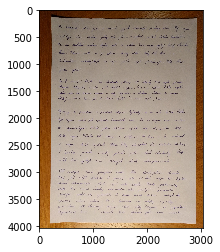

In [5]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

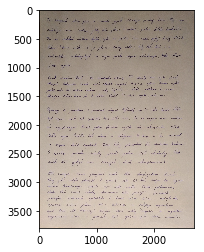

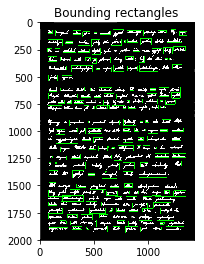

In [6]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

# Simple UI using widgets

In [7]:
class Cycler:
    """ Cycle through the chars, save data """
    height = 60
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.charIdx = 0         # Position po slider
        self.actual = image      # Current image of word
        self.char = None         # Actual char image
        self.nextImg()
        
    def save(self, sender, val=1):
        """ 
        Saving current char into dataset
        Saving the letter both in EN and CZ dataset
        """
        letter = sender.value
        sender.value = ""
        
        if self.char is None:
            self.nextChar()
        else:
            if len(letter) == 1:
                # Remove accents for EN dataset
                letterEN = ud.normalize('NFKD', letter)[0]

                # Saving both into cz and en dataset
                dirCZ = "data/charclas/cz/" + letter
                dirEN = "data/charclas/en/" + letterEN

                # Create dir if it doesn't exist
                os.makedirs(dirCZ, exist_ok=True)
                os.makedirs(dirEN, exist_ok=True)

                # Save the letter
                cv2.imwrite("%s/%s.jpg" % (dirCZ, time.time()), self.char)            
                cv2.imwrite("%s/%s.jpg" % (dirEN, time.time()), self.char)

                self.nextChar()                  
            else:
                print("Enter single letter.")  
        
    def nextChar(self, b=None):
        """ Ploting next char from the word """        
        # Clearing jupyter output for new image
        clear_output()
        idx = self.charIdx
        gaps = self.gaps
        
        if idx < len(gaps) - 1:
            # Cutting char image - for save function
            self.char = self.actual[0:self.height, gaps[idx]:gaps[idx+1]]
            implt(self.char, 'gray')
            self.charIdx += 1
        else:
            self.nextImg()

    def nextImg(self, b=None):
        """ Getting next image from the array """
        clear_output()
        self.char = None
        self.charIdx = 0
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            
            implt(img, t='Index: ' + str(self.index))            

            self.index += 1
            
            self.actual = imageNorm(img, self.height)
            
            self.gaps = charSeg.segmentation(self.actual, debug=True)
            
            return 0
        else:
            print("END")
            return -1

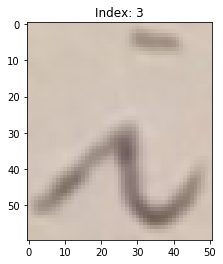

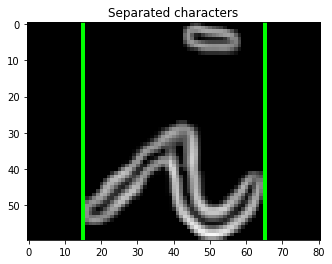

In [11]:
#  Last index
LAST_INDEX = 2
# Class cycling through text positions
cycler = Cycler(crop, bBoxes, LAST_INDEX)

# Create GUI
tSaver = Text(description="Save Char")
bNex = Button(description="Next Char")
bNexi = Button(description="Next Image")

tSaver.on_submit(cycler.save)
bNex.on_click(cycler.nextChar)
bNexi.on_click(cycler.nextImg)

VBox([tSaver, HBox([bNexi, bNex])])

In [7]:
### RULES FOR CREATING DATASET ###
#
# Label every possible letter, skip wrong det
# Differentiate between uppercase and lowercase
# Use all czech letters except CH
# If threre is image without char put 0
#
###################################


### Space for Notes ###
#
# Creat dataset paper
#
#######################